In [6]:
from occupancy import *

In [7]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation

In [8]:
alpha = 0.3
noise_level = 0
obj1, obj0 =  make_objs(blur_by=2) # previous image 
obj1, obj0 =  make_objs(n_pos=50,blur_by=5, delta_x=-7, delta_y=7, seed=4) # simpler image
vmax = np.max(obj0)
# obj1, obj0 = obj1/vmax, obj0/vmax
f_dark, f_light, delta_fa_abs = make_working_vars(obj1, obj0, alpha, old_version=False)
# make_working_vars(obj1, obj0, alpha, old_version=True) 


I simplified the image compared to what was there before.

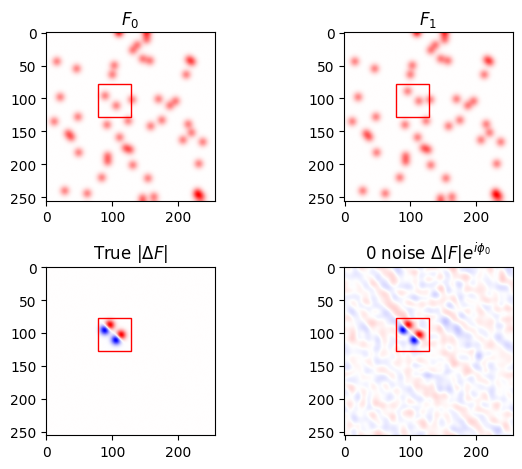

In [9]:
from matplotlib import patches 
fig, axsi = plt.subplots(2,2, tight_layout=True)
axs = axsi.flat
img_mid = 128
boxleng = -50

obj_diff = obj1-obj0
f_diff = np.fft.fftn(obj_diff)
obj_diff_conj = np.fft.ifftn(np.conj(f_diff)* np.exp(2j*np.angle(f_dark))).real
obj_diff_comb = (obj_diff + obj_diff_conj)/2


for ax in axs:
    rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
ax = axs[0]
ax.set_title(r"$F_0$")
ax.imshow(obj0, cmap= "bwr", vmin=-np.max(obj0))
ax = axs[1]
ax.set_title(r"$F_1$")
ax.imshow(obj1, cmap= "bwr", vmin = -np.max(obj0))

ax = axs[2]
ax.set_title(r"True $|\Delta F|$")
ax.imshow(obj_diff, cmap = "bwr", )

ax = axs[3]
ax.set_title(r"0 noise $\Delta |F|e^{i\phi_0}$")
ax.imshow(obj_diff_comb, cmap = "bwr",)
plt.show()


In [10]:
iso_diff_test = np.sum(np.abs(f_diff)) / np.sum(np.abs(f_dark))
print(f"Test whether F_Diff/F_0 ratio {iso_diff_test:.2f} < 0.25")

Test whether F_Diff/F_0 ratio 0.18 < 0.25


In [14]:
from scipy.ndimage import gaussian_filter
low = gaussian_filter(obj0,1)
high = gaussian_filter(obj0,1.6)
dog0 = low-high

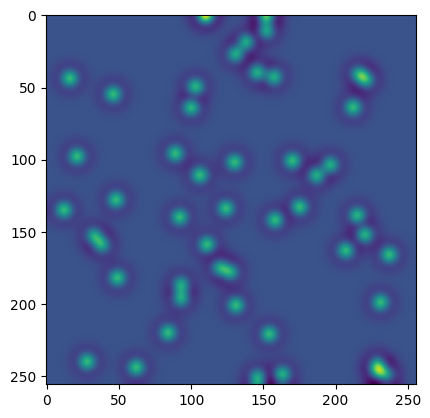

In [15]:
plt.imshow(dog0)

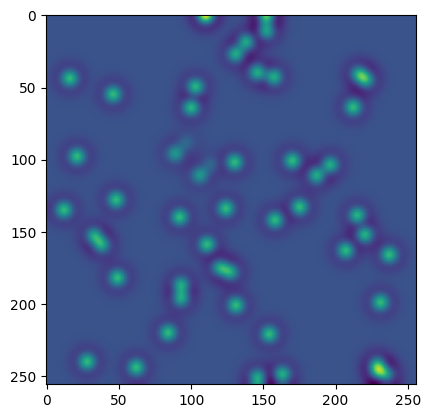

In [16]:
objMix = alpha*obj1+(1-alpha)*obj0
low = gaussian_filter(objMix,1)
high = gaussian_filter(objMix,1.6)
dogM = low-high
plt.imshow(dogM)


In [17]:
# import h5py
import meteor
import reciprocalspaceship as rs
import numpy as np
import gemmi 
import ipywidgets as widgets
from scipy.ndimage import gaussian_filter
# from output_eval import *

In [18]:
from occupancy import *
from plotting3d import *

In [53]:

dataloc = "../synthetic_cistrans/"
variant = "basic"
match variant:
    case "basic":
        name_dark = "trans_sf.mtz"
        name_light = "100ps_sf.mtz"
        alpha = 0.27
    case "basic-alt":
        name_dark = "trans_sf.mtz"
        name_light = "100ps_sfV2.mtz"
        alpha = 0.27
    case "noise":
        name_light = "100ps_withSIGFC_amplitudenoise.mtz"
        name_dark = "trans_withSIGFC_amplitudenoise.mtz"
        alpha = 0.27
    case "noise_high":
        name_light = "100ps_noise3.mtz"
        name_dark = "trans_noise3.mtz"
        ds_light = rs.read_mtz(dataloc+name_light)
        ds_dark = rs.read_mtz(dataloc+name_dark)
        ds_dark["sf"] = ds_dark.to_structurefactor("F_k", "PHI_k")
        ds_light["PHI_k"] = ds_dark["PHI_k"]
        ds_light["sf"] = ds_light.to_structurefactor("F_on", "PHI_k")
        
        alpha = 0.27


In [54]:
if not variant == "noise_high":
    ds_light = rs.read_mtz(dataloc+name_light)
    ds_dark = rs.read_mtz(dataloc+name_dark)

    ds_dark["sf"] = ds_dark.to_structurefactor("FC", "PHIC")
    ds_light["sf"] = ds_light.to_structurefactor("FC", "PHIC")
f_dark = ds_dark.to_reciprocal_grid("sf")
f_light = ds_light.to_reciprocal_grid("sf")
delta_fa_abs = np.abs(f_light)-np.abs(f_dark)

In [55]:
pdbname_light = dataloc+"100ps.pdb"
struc_light = gemmi.read_structure(pdbname_light)
pdbname_dark = dataloc + "trans.pdb"
struc_dark = gemmi.read_structure(pdbname_dark)

pos_list = np.array([(rca.atom.pos).tolist()   for rca in struc_light[0].all()])
for idx in range(3):
    diff = np.max(pos_list[:,idx])-np.min(pos_list[:,idx])


In [70]:
f_diff = 2/alpha*delta_fa_abs*np.exp(1j*np.angle(f_dark))
rho_diff = np.fft.ifftn(f_diff).real

In [88]:
fac = .4
low = gaussian_filter(rho_diff,fac)
high = gaussian_filter(rho_diff,fac*1.6)
dogM = low-high
# rho_diff = 

In [89]:
rho_pert = np.fft.fftn(f_light).real
mask = rho_diff>0.1
print(np.max(dogM))
np.max(rho_pert[mask])/np.max(rho_pert)

0.08592769537977335


np.float64(0.5178169161019128)

interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

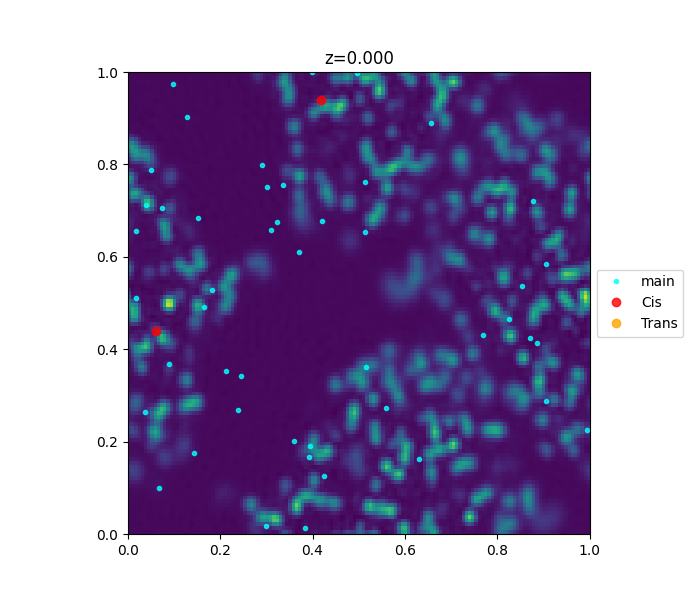

In [102]:
from plotting3d import get_pos_from_pdb
frac_list, occ_mask=get_pos_from_pdb(struc_light, search_occ=0.27)
%matplotlib widget
_ = mtz_comp(frac_list,occ_mask,  np.flip(rho_pert,(0,1,2)),extent=[0,1,1,0]) 
# _ = mtz_comp(frac_list,occ_mask,  np.flip(rho_diff.real*mask,(0,1,2)),extent=[0,1,1,0]) 


interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

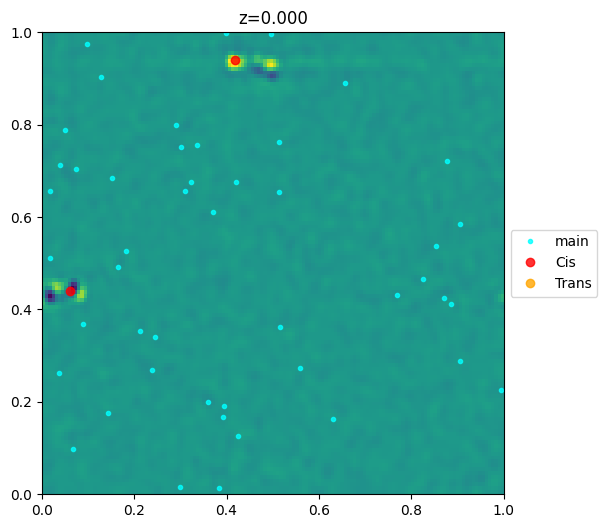

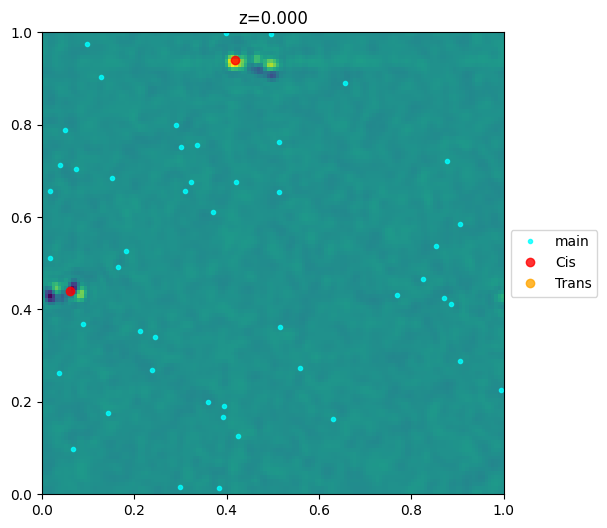

In [62]:
from plotting3d import get_pos_from_pdb
frac_list, occ_mask=get_pos_from_pdb(struc_light, search_occ=0.27)
_ = mtz_comp(frac_list,occ_mask,  np.flip(dogM.real,(0,1,2)),extent=[0,1,1,0]) 
_ = mtz_comp(frac_list,occ_mask,  np.flip(rho_diff.real,(0,1,2)),extent=[0,1,1,0]) 
